# Analyse de sentiments

Classification des discours haineux !

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## A propos des donnees

In [2]:
file_path = 'twitter_sentiments.csv'

In [3]:
data = pd.read_csv(file_path)

In [7]:
data.head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


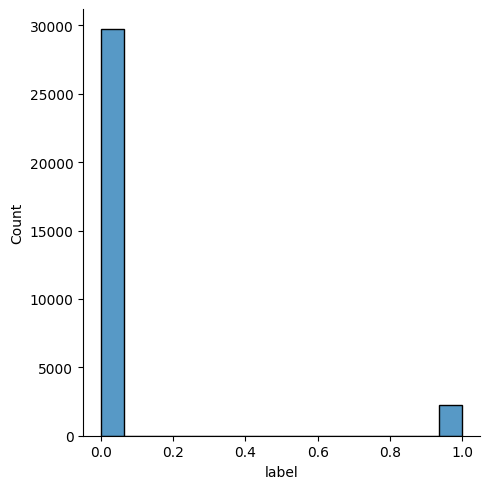

In [23]:
sns.displot(data['label'])

....

## Nettoyage des Données

In [19]:
import re
from nltk.corpus import stopwords

def clean_data(row):
    tweet = row['tweet']
    # lower
    tweet = tweet.lower()
    # remove hash tag
    tweet = tweet.replace('#', '')
    # remove special characters
    tweet = re.sub('[^a-z\s]', '', tweet)
    # remove all words with len(word) < 3
    tweet = ' '.join([w for w in tweet.split() if len(w) > 2])
    # remove stopwords
    list_stopwords = stopwords.words("english")
    tweet = ' '.join([w for w in tweet.split() if w not in list_stopwords])
    
    return tweet

In [20]:
data['clean_tweet'] = data.apply(lambda row: clean_data(row), axis=1)

In [22]:
data.head(5)

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,user father dysfunctional selfish drags kids d...
1,2,0,@user @user thanks for #lyft credit i can't us...,user user thanks lyft credit cant use cause do...
2,3,0,bihday your majesty,bihday majesty
3,4,0,#model i love u take with u all the time in ...,model love take time
4,5,0,factsguide: society now #motivation,factsguide society motivation


Remove top 25 most frequent words

In [25]:
all_tweets = ' '.join(data['clean_tweet'])

In [40]:
most_frequent_words_top_25 = pd.Series(all_tweets.split()).value_counts()[:25]

In [44]:
def remove_top_25_most_frequent_words(row):
    tweet = row['clean_tweet']
    tweet = ' '.join([w for w in tweet.split() if w not in list(most_frequent_words_top_25.index)])
    return tweet

In [45]:
data['clean_tweet_without_top_25_most_frequent_words'] = data.apply(lambda row: remove_top_25_most_frequent_words(row), axis=1)

In [47]:
data.head(3)

,id,label,tweet,clean_tweet,clean_tweet_without_top_25_most_frequent_words
0,1,0,@user when a father is dysfunctional and is s...,user father dysfunctional selfish drags kids d...,father dysfunctional selfish drags kids dysfun...
1,2,0,@user @user thanks for #lyft credit i can't us...,user user thanks lyft credit cant use cause do...,thanks lyft credit use cause offer wheelchair ...
2,3,0,bihday your majesty,bihday majesty,majesty


## Tweet to vectors

In [48]:
import spacy

nlp = spacy.load('en_core_web_lg')

In [51]:
def tweet2vec(row):
    tweet = row['clean_tweet_without_top_25_most_frequent_words']
    tweet_vector = nlp(tweet).vector
    return tweet_vector

In [54]:
data['tweet_vector'] = data.apply(lambda row: tweet2vec(row), axis=1)

In [55]:
data.head(1)

,id,label,tweet,clean_tweet,clean_tweet_without_top_25_most_frequent_words,tweet_vector
0,1,0,@user when a father is dysfunctional and is s...,user father dysfunctional selfish drags kids d...,father dysfunctional selfish drags kids dysfun...,"[-0.1594863, 1.1605057, -2.023615, -0.80235493..."


## Entrainement du modele

Split Train/Test

In [68]:
from sklearn.model_selection import train_test_split

X = data['tweet_vector']
y = data['label']

print("Total des donnees : ", len(X))

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=10)

X_train = X_train.tolist()
X_test = X_test.tolist()

print("Total des donnees (Training) : ", len(X_train))
print("Total des donnees (Testing) : ", len(X_test))

Total des donnees :  31962
Total des donnees (Training) :  25569
Total des donnees (Testing) :  6393


Training

In [85]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=10, max_iter=1000).fit(X_train, y_train)
model.score(X_train, y_train)

0.9471625796863389

Testing

In [86]:
y_pred = model.predict(X_test)
model.score(X_test, y_test)

0.9440012513686845

[[5868   77]
 [ 281  167]]


<AxesSubplot: >

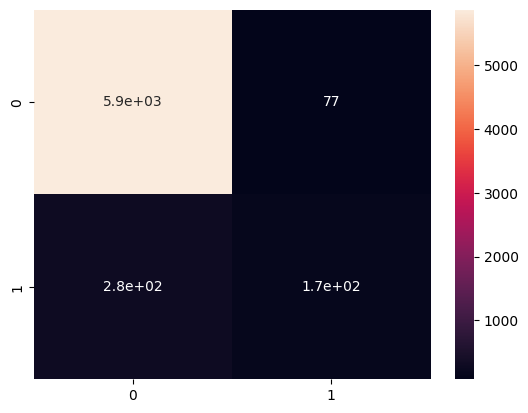

In [87]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print(cm)
sns.heatmap(cm, annot=True)

In [91]:
# Accuracy, Precision, Recall, F-Score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fscore = f1_score(y_test, y_pred)

print("Accuracy : ", accuracy)
print("Precision : ", precision)
print("Recall : ", recall)
print("F-score : ", fscore)

Accuracy :  0.9440012513686845
Precision :  0.6844262295081968
Recall :  0.37276785714285715
F-score :  0.4826589595375723


## Deploiement

In [92]:
# Export

to_export = dict()
to_export['data_cleaning'] = [clean_data, remove_top_25_most_frequent_words]
to_export['tweet2vec'] = tweet2vec
to_export['model'] = model

In [99]:
type(to_export['model'])

sklearn.linear_model._logistic.LogisticRegression

In [100]:
import dill as pickle

fichier = open('tweet_sentiment_analysis_model.pkl', mode='wb')
pickle.dump(to_export, fichier)
fichier.close()